### 1.1 Data Acquisition and Alignment

#### Import libraries

In [2]:
import os
import rasterio
import numpy as np
from torch.utils.data import DataLoader
import gc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
from torchvision import transforms
from rasterio.plot import show

from acquisition_alignment.dl_functions import download_osm, get_building_bbox, download_sentinel2_images_openeo
from acquisition_alignment.connect_openeo import connect_to_openeo
from acquisition_alignment.plt_functions import plot_city_buildings, rgb_image, single_band_image, overlay_image, irb_image, get_epsg_from_tif, reproject_gdf

from preparation.preparation import extract_patches
from preparation.gen_dataset import pair_files, split_and_save

from modeling_tuning.build_dataset import BuildingDataset
from modeling_tuning.build_classifier import BuildingClassifierBaseline, BuildingClassifierUnet
from modeling_tuning.earlystopping import EarlyStopping

c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Loop through 10 'big' cities and download OSM Data

In [3]:
pyrosm_path = f"acquisition_alignment/pyrosm_cities/"
os.makedirs(pyrosm_path, exist_ok=True)

# List of 10 'big' cities + Test city
city_names = ["Berlin", "Bonn", "Muenchen", "Koeln", "Frankfurt", "Stuttgart", "Dortmund", "Duesseldorf", "Bremen", "Leipzig", "Dresden"]

In [ ]:
# 1 min
# Loop through each city
for city in city_names:
    #Download and process OSM data
    download_osm(city, pyrosm_path)
    print(f"Download of {city} done.\n")

#### Load buildings and bboxes of the cities

##### Save shape files (not used)

In [ ]:
import json

def save_to_shapefile(buildings_gdf, bbox, city_name):
    # Define the path to save files
    files_path = "acquisition_alignment/pyrosm_cities/buildings/"
    os.makedirs(files_path, exist_ok=True)
    
    # Save buildings GeoDataFrame to shapefile
    buildings_gdf.to_file(files_path+f"{city_name}_buildings.shp")
    
    # Save bbox to JSON file
    north, south, west, east = bbox
    bbox_dict = {
        "north": north,
        "south": south,
        "west": west,
        "east": east
    }
    
    with open(files_path + f"{city_name}_bbox.json", "w") as json_file:
        json.dump(bbox_dict, json_file, indent=4)

##### Extract buildings and bboxes

In [4]:
# ~11 min
cities_data = {}
for city in city_names[:2]:
    buildings_gdf, bbox = get_building_bbox(pyrosm_path, city)
    # Saving buildings_gdf to a shapefile
    # save_to_shapefile(buildings_gdf, bbox, city)
    cities_data[city] = [buildings_gdf, bbox]
    print(f"Get buildings and boundaries of {city} done.\n")


c:\Users\PC\Desktop\TU\AMLS\acquisition_alignment\pyrosm_cities\Berlin.osm.pbf
OSM data get_buildings done.
OSM for Berlin converted into GeoDataFrame, with crs=EPSG:4326 done.
OSM data get_boundaries done.
Get buildings and boundaries of Berlin done.

c:\Users\PC\Desktop\TU\AMLS\acquisition_alignment\pyrosm_cities\Bonn.osm.pbf
OSM data get_buildings done.
OSM for Bonn converted into GeoDataFrame, with crs=EPSG:4326 done.
OSM data get_boundaries done.
Get buildings and boundaries of Bonn done.



In [ ]:
print(cities_data["Bonn"])

#### Download Satellite images (.tif files) and plotting

##### Connect to openeo.dataspace.copernicus

In [ ]:
# Connect to OpenEO
connection = connect_to_openeo()

##### Download Sentinel 2 L2a Data

In [ ]:
# 30 - 40 min
dates_interval = ["2021-06-01T12:00:00Z", "2021-07-30T12:01:00Z"]
cloud_cover_percentage = 6

for city in city_names:
    openeo_path = f"acquisition_alignment/openeo_cities/{city}/"
    # Ensure the directory exists
    os.makedirs(openeo_path, exist_ok=True)

    # Download Sentinel-2 L2a images
    _, bbox = cities_data[city]
    download_sentinel2_images_openeo(connection, bbox, dates_interval, cloud_cover_percentage, openeo_path)

##### Buildings Plot and Images

In [ ]:
# 
band_index = 1  # For single band. Band index to read (1 for B04, 2 for B03, 3 for B02, 4 for B08) (cmap=gray anyway)

# Loop through each city in the dictionary and save image of the buildings of the city
for city, data in cities_data.items():
    # Path to the Sentinel-2 L2a image of a city
    sentinel2_path = f"acquisition_alignment/openeo_cities/{city_names}/{city}.tif"

    buildings_gdf, _ = data

    # Make directory for the images (for city). Ensure the directory exists
    images_save_dir = f"acquisition_alignment/images/{city}/"
    os.makedirs(images_save_dir, exist_ok=True)

    print("1 (a) Buildings from OpenStreetMaps.")
    plot_city_buildings(city, buildings_gdf, images_save_dir)

    print("1 (b) RGB Bands from Sentinel 2.")
    rgb_image(sentinel2_path, images_save_dir)

    print("2 (a) Single Band.")
    single_band_image(sentinel2_path, images_save_dir, band_index)

    print("2 (b) Overlap Buildings from OSM onto Sentinel-2 image.")
    overlay_image(buildings_gdf, sentinel2_path, images_save_dir, band_index)

    print("2 (c) IRB")
    irb_image(sentinel2_path, images_save_dir)
    
    break # One should be enough to be sure everything is correct

### 1.2 Dataset Preparation

##### Save huge mask for each huge city in a .tif file

In [47]:
# 12.2 min
import rasterio
import numpy as np

# Patch extraction
patch_size = 128  # Example patch size

# Load the Sentinel-2 image
for city, data in cities_data.items():
    image_path = f"acquisition_alignment/openeo_cities/{city}/{city}.tif"  # Iterate over each of the 10 Sentinel files
    buildings_gdf, _ = data
    satellite_crs = get_epsg_from_tif(image_path)
    buildings_gdf = reproject_gdf(buildings_gdf, satellite_crs) # OSM to Satellite

    with rasterio.open(image_path) as src:
        transform = src.transform
        width = src.width
        height = src.height

        # Read the image bands as integers. Bands are starting from 1 here (with rasterio) because its: <class 'rasterio.io.DatasetReader'> and not numpy array
        """red = src.read(1).astype(np.float32)  # B04
        green = src.read(2).astype(np.float32)  # B03
        blue = src.read(3).astype(np.float32)  # B02
        ir = src.read(4).astype(np.float32)  # B08

        # Normalize each band to [0, 1] values
        red = (red - np.min(red)) / (np.max(red) - np.min(red))
        green = (green - np.min(green)) / (np.max(green) - np.min(green))
        blue = (blue - np.min(blue)) / (np.max(blue) - np.min(blue))
        ir = (ir - np.min(ir)) / (np.max(ir) - np.min(ir))

        sentinel_image = np.dstack((red, green, blue, ir))  # [H, W, C]. Bands are starting from 0 here
        print(sentinel_image.shape, city)"""

        # Create the building mask
        buildings_mask = create_building_mask(buildings_gdf, transform, width, height) # 0/1 = black white

        # Save the building mask as a new .tif file
        mask_path = f'acquisition_alignment/openeo_cities/{city}/{city}_buildings_mask.tif'
        with rasterio.open(
            mask_path,
            'w',
            driver='GTiff',
            height=buildings_mask.shape[0],
            width=buildings_mask.shape[1],
            count=1,
            dtype=buildings_mask.dtype,  # use the same data type as the mask
            crs=src.crs,
            transform=transform,
        ) as dst:
            dst.write(buildings_mask, 1)

(1360, 1425, 4) Berlin
(4884, 4080, 4) Bonn


##### Load .tif mask files and look at them

Unique values in mask: [0 1]


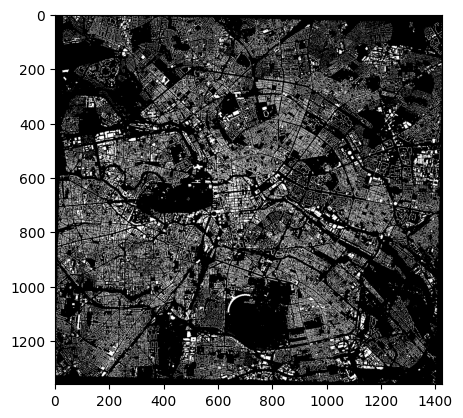

Unique values in mask: [0 1]


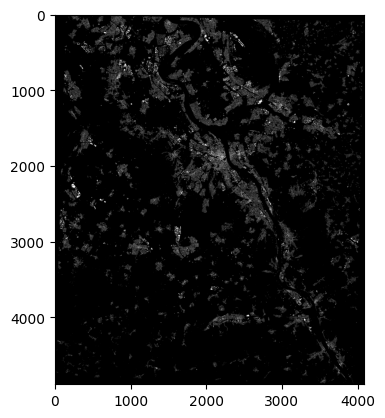

Unique values in mask: [0 1]


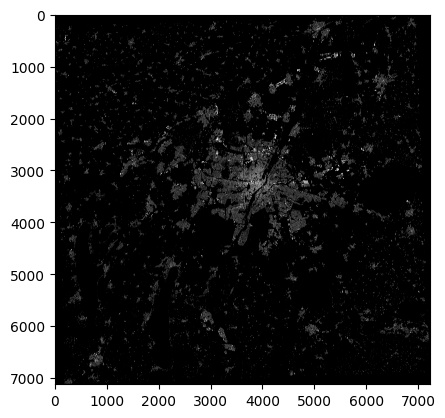

Unique values in mask: [0 1]


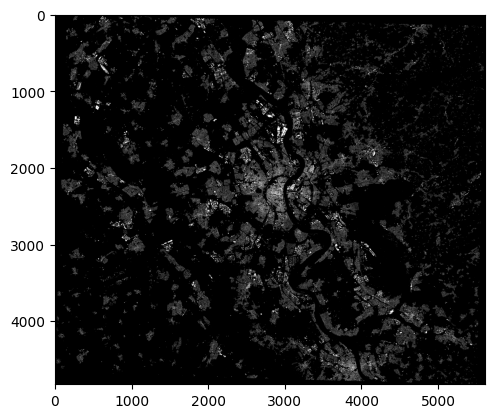

In [5]:
for city in city_names[:4]:
    mask_path = f'acquisition_alignment/openeo_cities/{city}/{city}_buildings_mask.tif'
    # Load the building mask
    with rasterio.open(mask_path) as src:
        buildings_mask = src.read(1)  # Mask is in the first band

    # Check the unique values in the mask
    unique_values = np.unique(buildings_mask)
    print("Unique values in mask:", unique_values)

    # Display the mask with a grayscale colormap
    show(buildings_mask, cmap='gray')

##### Prepare Trainset

In [21]:
# 20 sec
all_image_patches = []
all_mask_patches = []

# Example city names list
patch_size = 128  # Define your patch size

# Process all cities except Berlin and the last two for validation
for city in city_names[1:-2]:  # Berlin is at index 0, 2 other for validation
    image_file = f'acquisition_alignment/openeo_cities/{city}/{city}.tif'
    mask_file = f'acquisition_alignment/openeo_cities/{city}/{city}_buildings_mask.tif'
    
    # Open city image and mask using rasterio
    with rasterio.open(image_file) as src_img:
        sentinel_image = src_img.read()  # Read all bands
        sentinel_image = np.moveaxis(sentinel_image, 0, -1)  # Move axis to (H, W, C).
        # Normalize the 4 bands to [0, 1]
        sentinel_image = sentinel_image / np.max(sentinel_image, axis=(0, 1))

    with rasterio.open(mask_file) as src_mask:
        buildings_mask = src_mask.read(1)  # Read mask, assuming it's a single band

    # Extract patches and convert to torch tensors
    tensor_image, tensor_mask = extract_patches(sentinel_image, buildings_mask, patch_size)
    # Collect all patches
    all_image_patches.append(tensor_image)
    all_mask_patches.append(tensor_mask)
# Stack all patches into single tensors
all_image_patches = torch.cat(all_image_patches, dim=0)
all_mask_patches = torch.cat(all_mask_patches, dim=0)

print(f"Total image patches shape: {all_image_patches.shape}")
print(f"Total mask patches shape: {all_mask_patches.shape}")

Total image patches shape: torch.Size([10053, 128, 128, 4])
Total mask patches shape: torch.Size([10053, 128, 128])


In [22]:
# Ensure the dimensions are [N, H, W, C] for images and [N, H, W] for masks
all_image_patches = all_image_patches.permute(0, 1, 2, 3)
all_mask_patches = all_mask_patches.permute(0, 1, 2)

# Output
print("Image tensor shape:", all_image_patches.shape)
print("Mask tensor shape:", all_mask_patches.shape)

Image tensor shape: torch.Size([10053, 128, 128, 4])
Mask tensor shape: torch.Size([10053, 128, 128])


##### Look at some of the patches and masks

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.011107353..0.4662395].


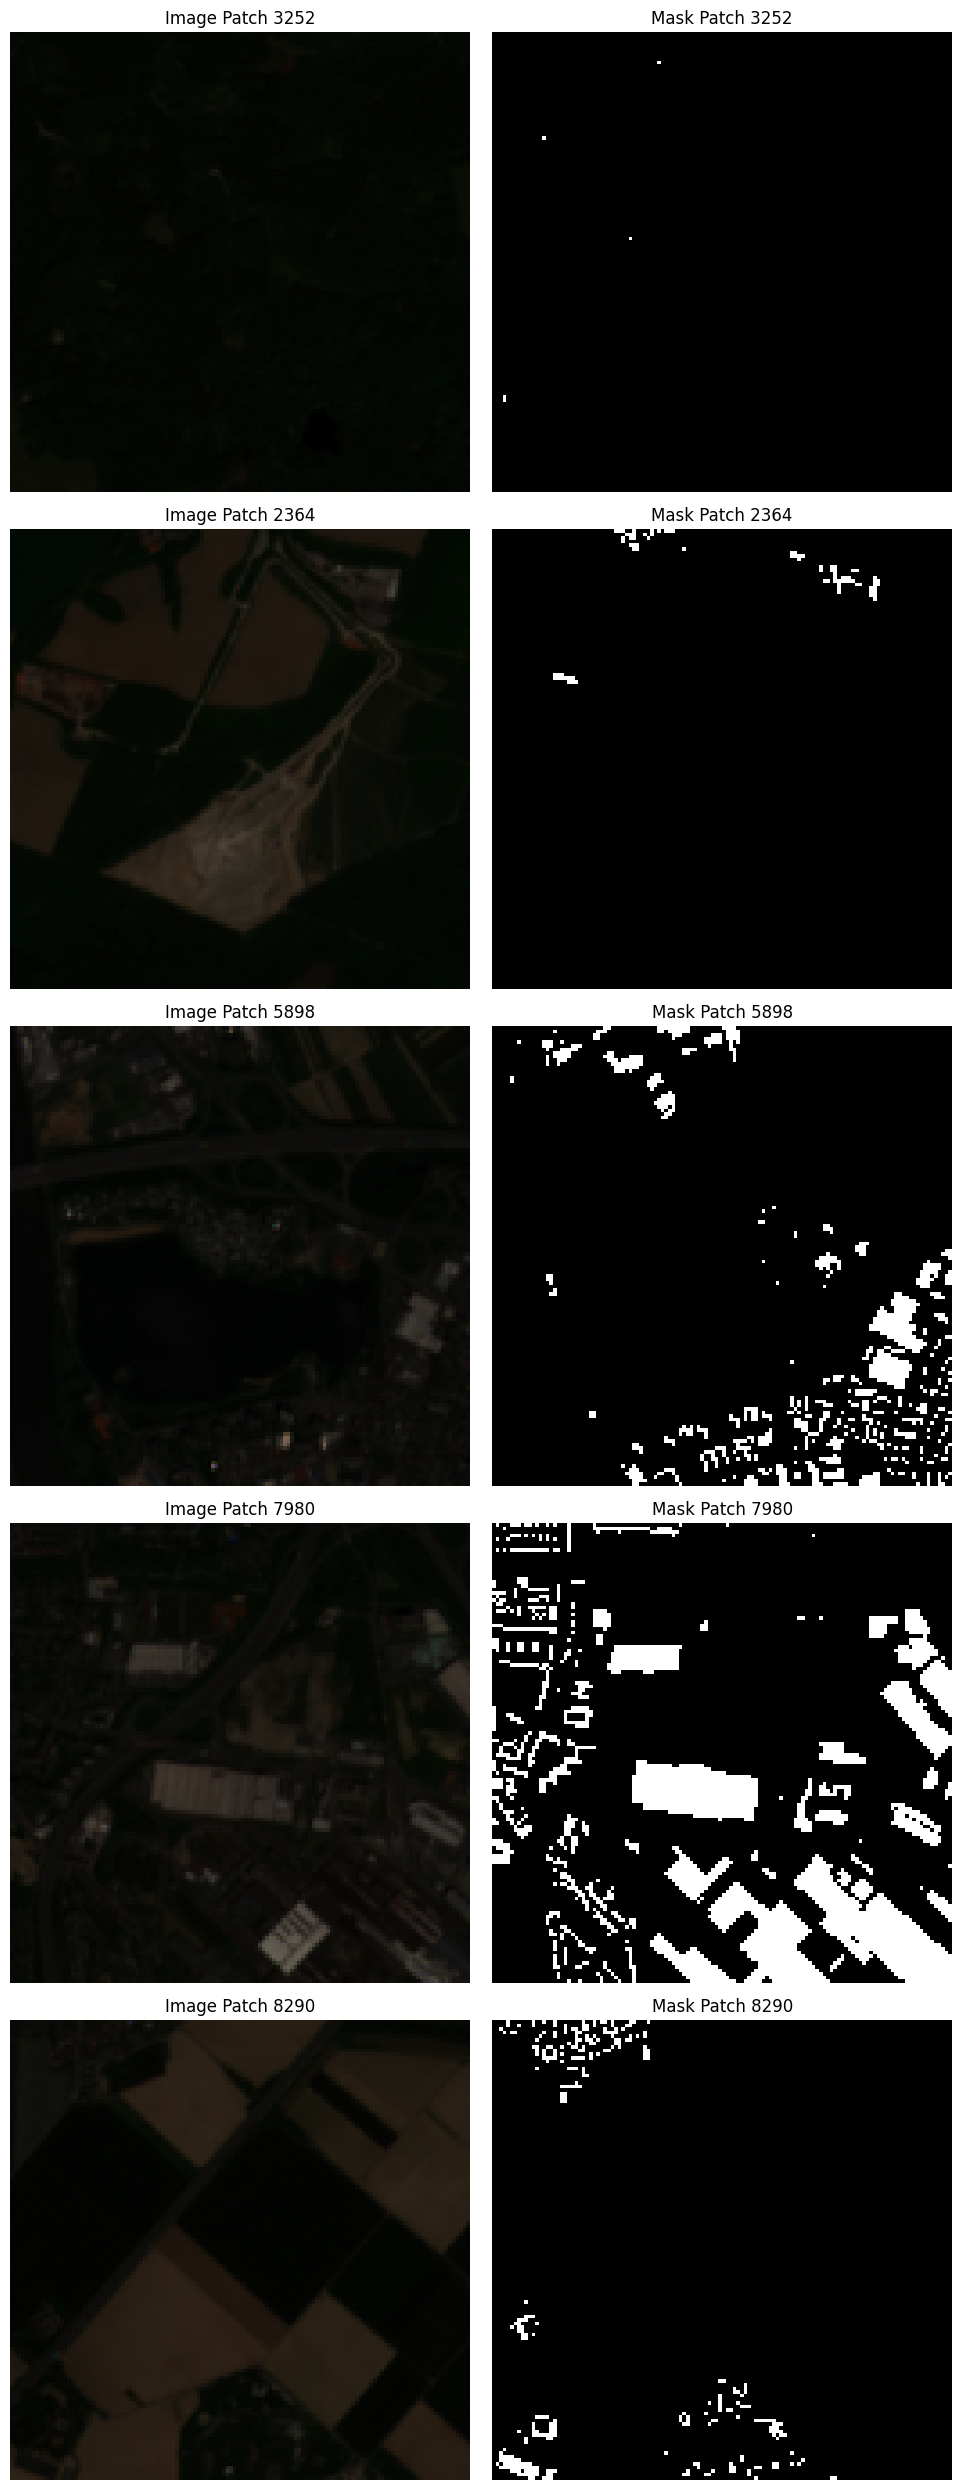

In [23]:
# Visualize 10 random patches
import matplotlib.pyplot as plt

num_patches_to_show = 5
random_indices = np.random.choice(all_image_patches.shape[0], num_patches_to_show, replace=False)

fig, axes = plt.subplots(num_patches_to_show, 2, figsize=(10, num_patches_to_show * 5))
for i, idx in enumerate(random_indices):
    image_patch = all_image_patches[idx].numpy()
    mask_patch = all_mask_patches[idx].numpy()
    
    axes[i, 0].imshow(image_patch[:, :, :3])  # Show RGB bands only
    axes[i, 0].set_title(f"Image Patch {idx}")
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(mask_patch, cmap='gray')
    axes[i, 1].set_title(f"Mask Patch {idx}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


#### Save all images and all patches

In [26]:
from torchvision.utils import save_image

# Save images and labels
os.makedirs('preparation/data/train_images', exist_ok=True)
os.makedirs('preparation/data/train_masks', exist_ok=True)

# Save all image patches
for i in range(all_image_patches.shape[0]):
    image_patch = all_image_patches[i].permute(2, 0, 1)  # Permute to (C, H, W) for saving with save_image
    save_image(image_patch, f'preparation/data/all_images/image_patch_{i}.png')

# Save all mask patches
for i in range(all_mask_patches.shape[0]):
    mask_patch = all_mask_patches[i].unsqueeze(0)  # Add channel dimension for saving with save_image
    save_image(mask_patch.float(), f'preparation/data/all_masks/mask_patch_{i}.png')

print("All image patches and mask patches saved successfully.")

All image patches and mask patches saved successfully.


#### Create Validation set

#### Make pairs: (patch, patch_mask)

In [ ]:
image_dir = 'preparation/data/all_images'
mask_dir = 'preparation/data/all_masks'
# For splitting
paired_files = pair_files(image_dir, mask_dir)
print(len(paired_files))

#### Split Dataset into train and val and save

In [ ]:
output_directory = 'preparation/data'
split_and_save(paired_files, output_directory)

### 1.3 Modeling and Tuning

#### Set device

In [ ]:
torch.cuda.empty_cache()
gc.collect()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#### Hyperparameters

In [ ]:
# Parameters: in_channels, lr, weight_decay, num_epochs, batch_size, patience, min_delta, optimizer_type
params_list = [
    (3, 0.001, 1e-4, 10, 16, 5, 0.001, 'adam'),
    (3, 0.001, 1e-4, 20, 16, 5, 0.001, 'sgd'),
]
batch_size = 16

#### BuildDataset

In [ ]:
transform = transforms.ToTensor()

# Load the train dataset
train_image_dir = "preparation/data/train/images" 
train_mask_dir = "preparation/data/train/masks"
train_dataset = BuildingDataset(train_image_dir, train_mask_dir, transform)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)

# Load the validation dataset
val_image_dir = "preparation/data/val/images" 
val_mask_dir = "preparation/data/val/masks"
val_dataset = BuildingDataset(val_image_dir, val_mask_dir, transform)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

# Load the test dataset (Berlin)
# test_image_dir = "preparation/data/test/images"
# test_mask_dir = "preparation/data/test/masks"
# test_dataset = BuildingDataset(test_image_dir, test_mask_dir, transform)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

#### Baseline Model

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_modelB(params):
    print(f"Params: {params}")
    in_channels, lr, weight_decay, num_epochs, batch_size, patience, min_delta, optimizer_type = params

    model = BuildingClassifierBaseline(in_channels).to(device)
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss with logits
    
    early_stopping = EarlyStopping(patience=patience, min_delta=min_delta)
    
    # Select optimizer based on the parameter
    if optimizer_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_type == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unknown optimizer type: {optimizer_type}")

    print("Training started")
    
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
        for images, masks in train_loader_tqdm:
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            outputs = outputs.squeeze(1)  # Remove channel dimension
            masks = masks.squeeze(1)
            
            loss = criterion(outputs, masks)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_loader_tqdm.set_postfix({"Loss": loss.item()})
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")
        with torch.no_grad():
            for images, masks in val_loader_tqdm:
                images, masks = images.to(device), masks.to(device)
                
                outputs = model(images)
                outputs = outputs.squeeze(1)
                masks = masks.squeeze(1)
                
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                val_loader_tqdm.set_postfix({"Loss": loss.item()})
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Check early stopping condition
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break
    
    # Save the model
    model_save_path = f'models/'
    os.makedirs(model_save_path, exist_ok=True)
    
    model_name = f"Baseline_{in_channels}_{lr}_{weight_decay}_{batch_size}_{optimizer_type}.pth"
    torch.save(model.state_dict(), os.path.join(model_save_path, model_name))
    print(f"Model saved to {model_save_path + model_name}")
    
    # Plot train and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss over Epochs for the Baseline Model')
    plt.xticks(range(1, epoch + 1))  # Set x-axis ticks to integers only
    plt.legend()
    plt.show()

##### Start training

In [ ]:
"""def run_in_parallel():
    pool = Pool(processes=len(params_list))
    pool.map(train_model, params_list)

run_in_parallel()
"""

for p in params_list:
    train_modelB(p)

##### Test Baseline Model

In [ ]:
def evaluate_model(model_path, test_loader, m):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the model
    if m == "b":
        model = BuildingClassifierBaseline(in_channels=3)  # input channels
    else:
        model = BuildingClassifierUnet(in_channels=3)  # input channels
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss with logits

    test_loss = 0.0
    all_outputs = []
    all_masks = []

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            outputs = outputs.squeeze(1)
            masks = masks.squeeze(1)
            
            loss = criterion(outputs, masks)
            test_loss += loss.item()
            
            all_outputs.append(outputs.cpu().numpy())
            all_masks.append(masks.cpu().numpy())

    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")

    return np.concatenate(all_outputs), np.concatenate(all_masks)

def compute_metrics(predicted_masks, true_masks, threshold=0.5):
    predicted_masks = (predicted_masks > threshold).astype(int)
    true_masks = true_masks.astype(int)
    
    # Flatten the masks to compute metrics
    predicted_masks_flat = predicted_masks.flatten()
    true_masks_flat = true_masks.flatten()
    
    accuracy = accuracy_score(true_masks_flat, predicted_masks_flat)
    precision = precision_score(true_masks_flat, predicted_masks_flat)
    recall = recall_score(true_masks_flat, predicted_masks_flat)
    f1 = f1_score(true_masks_flat, predicted_masks_flat)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

##### Eval Baseline

In [ ]:
model_path = 'models/Baseline_3_0.001_0.0001_16_adam.pth'
predicted_masks, true_masks = evaluate_model(model_path, test_loader, "b")

# Compute the metrics
compute_metrics(predicted_masks, true_masks)

##### Visual Baseline one of the Baseline Models

In [ ]:
def visualize_predictions(test_loader, model_path, m, num_images=5):
    # Load the model
    if m == "b":
        model = BuildingClassifierBaseline(in_channels=3)  # input channels
    else:
        model = BuildingClassifierUnet(in_channels=3)  # input channels
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    with torch.no_grad():
        for idx, (images, masks) in enumerate(test_loader):
            images, masks = images.to(device), masks.to(device)
            
            # Get model outputs
            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu().numpy()
            preds = (preds > 0.5).astype(np.uint8)
            
            for i in range(min(num_images, images.size(0))):
                fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                
                # Original image
                axs[0].imshow(images[i].cpu().permute(1, 2, 0))
                axs[0].set_title("Original Image")
                axs[0].axis("off")
                
                # Ground truth mask
                axs[1].imshow(masks[i].cpu().squeeze(), cmap="gray")  # Squeeze to remove the channel dimension
                axs[1].set_title("Ground Truth Mask")
                axs[1].axis("off")
                
                # Predicted mask
                axs[2].imshow(preds[i], cmap="gray")  # Directly use preds[i] since it's already squeezed
                axs[2].set_title("Predicted Mask")
                axs[2].axis("off")
                
                plt.show()
            
            # Stop after visualizing num_images
            if idx * test_loader.batch_size + i + 1 >= num_images:
                break

# Visualize the first 5 predictions in the test set
visualize_predictions(test_loader, model_path, "b", num_images=5)

#### Unet Model

In [ ]:
# Parameters: 

In [ ]:
# Example usage
model = BuildingClassifierUnet(in_channels=3)  # Input channels = 3 (RGB)

In [ ]:
def train_modelU(train_loader, val_loader, model, criterion, optimizer, device, num_epochs=10, patience=5, min_delta=0):
    early_stopping = EarlyStopping(patience=patience, min_delta=min_delta)
    
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
        for images, masks in train_loader_tqdm:
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            outputs = outputs.squeeze(1)  # Remove channel dimension
            masks = masks.squeeze(1)

            loss = criterion(outputs, masks)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_loader_tqdm.set_postfix({"Loss": loss.item()})
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")
        with torch.no_grad():
            for images, masks in val_loader_tqdm:
                images, masks = images.to(device), masks.to(device)
                
                outputs = model(images)
                outputs = outputs.squeeze(1)
                masks = masks.squeeze(1)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                val_loader_tqdm.set_postfix({"Loss": loss.item()})
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        # Check early stopping condition
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break
    
    # Plot train and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epoch + 2), train_losses, label='Train Loss')
    plt.plot(range(1, epoch + 2), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss over Epochs')
    plt.legend()
    plt.show()
    
    return model

##### Train Unet Model

In [ ]:
# Define model, criterion, optimizer
model = BuildingClassifierUnet(in_channels=3).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
trained_model = train_modelU(train_loader, val_loader, model, criterion, optimizer, device)

# Save the model
model_save_path = f'models/'
os.makedirs(model_save_path, exist_ok=True)
torch.save(trained_model.state_dict(), model_save_path+f"Unet.pth")

##### Eval Unet

In [ ]:
model_path = 'models/Unet.pth'
predicted_masks, true_masks = evaluate_model(model_path, test_loader, "u")

# Compute the metrics
compute_metrics(predicted_masks, true_masks)

##### Visual Unet

In [ ]:
visualize_predictions(test_loader, model_path, "u", num_images=5)

### 1.4 Data Augmentation